Project Proposal: https://docs.google.com/document/d/1rRzJV0hOaNMsBIjji8v1Cv8C3QUuZ6lUvYokZ5dif-A/edit


In [1]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing 
import warnings
from scipy import stats

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
#import sys

credentials = []
f = open('credentials.txt', 'r')
for line in f:
    #add line to credentials list (remove trailing whitespace characters)
    credentials.append(line.rstrip())

# create Spotify object with credentials
client_credentials_manager = SpotifyClientCredentials(credentials[0], credentials[1])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [2]:
df = pd.read_csv("/Users/gregwelliver/Desktop/springboard_files/Music-Capstone-Project-Repo/Data/Merged_Data7.csv", index_col=[0])

In [3]:
df.isna().sum()

track_id                 0
track_name               0
track_genre              0
artist_name              0
track_popularity         0
popular_year             0
Top100                   0
key                      0
acousticness             0
danceability             0
duration_ms              0
energy                   0
instrumentalness         0
liveness                 0
loudness                 0
modality                 0
speechiness              0
tempo                    0
time_signature           0
valence                  0
second_artist       230971
artist_country       71786
collaboration            0
prevTop100               0
Label               153863
dtype: int64

## EDA

In [4]:
### QUESTION: when we have a categorical independent variable, is there much EDA that we can do with it?
### QUESTION: what do with variables we know are categorical, but python is reading as continuous (e.g. key, modality)

In [5]:
#df4.popular_year = int(df4.popular_year)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255096 entries, 0 to 822121
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          255096 non-null  object 
 1   track_name        255096 non-null  object 
 2   track_genre       255096 non-null  object 
 3   artist_name       255096 non-null  object 
 4   track_popularity  255096 non-null  float64
 5   popular_year      255096 non-null  int64  
 6   Top100            255096 non-null  object 
 7   key               255096 non-null  float64
 8   acousticness      255096 non-null  float64
 9   danceability      255096 non-null  float64
 10  duration_ms       255096 non-null  float64
 11  energy            255096 non-null  float64
 12  instrumentalness  255096 non-null  float64
 13  liveness          255096 non-null  float64
 14  loudness          255096 non-null  float64
 15  modality          255096 non-null  float64
 16  speechiness       25

In [7]:
df['popular_year'] = df['popular_year'].fillna(0)
df['popular_year'] = df['popular_year'].astype(int)

### Selection of dependent variable:

The goal of our model is to determine if a song will place on the Top 100 in a given year.  This is represented byt he Top100 variable. Let's explore the dependent variable further.

In [8]:
# subset of tracks that made top 100
TopSongs = df[df['Top100'] == "Y"]

In [51]:
len(TopSongs)

1863

The data sample runs from the year 2000 through 2021, and there are 100 tracks in the Top Songs list for each year.  This means that we were able to get 88% of possible records (1863/2100) in our data retrieval.

In [10]:
#print(TopSongs[['track_name', 'second_artist']])

In [25]:
#TopSongs.groupby(['artist_name','popular_year']).count().reset_index()

### Artists

Let's first take a look at the Artists that earned Top Song status over this time period

In [65]:
Artists_Grouped = TopSongs['artist_name'].value_counts().reset_index()
Artists_Grouped.index = Artists_Grouped.index + 1
Artists_Grouped.columns = ['Artist', 'Count']
Artists_Grouped = Artists_Grouped.head(30)
Artists_Grouped

,Artist,Count
1,Drake,26
2,Taylor Swift,25
3,Rihanna,25
4,Eminem,22
5,Ariana Grande,20
6,Calvin Harris,19
7,P!nk,18
8,Beyoncé,18
9,Britney Spears,16
10,Justin Bieber,16


We can see that there five artists that had at least 20 Top Songs over this time period, and twenty-eight artists that had at least 10 Top Songs.

In [66]:
Artists_Grouped_Year = TopSongs[['artist_name', 'popular_year']].value_counts().reset_index()
Artists_Grouped_Year.index = Artists_Grouped_Year.index + 1
Artists_Grouped_Year.columns = ['Artist', 'Year', 'Count']
Artists_Grouped_Year = Artists_Grouped_Year.head(30)
Artists_Grouped_Year

,Artist,Year,Count
1,Ed Sheeran,2017,5
2,Rihanna,2010,5
3,Lady Gaga,2009,5
4,Drake,2018,5
5,Doja Cat,2021,5
6,Marshmello,2018,4
7,Taylor Swift,2015,4
8,Calvin Harris,2013,4
9,Ariana Grande,2021,4
10,50 Cent,2003,4


The most Top Songs produced by an artist in any one year is five, and this has been done by five different artists.  Four Top Songs was much more frequent, having been achieved by fifteen different artists in the time period.

Let's view a time series of the top artists


In [69]:
top5Artists = list(Artists_Grouped['Artist'])[0:5]
top5Artists

['Drake', 'Taylor Swift', 'Rihanna', 'Eminem', 'Ariana Grande']

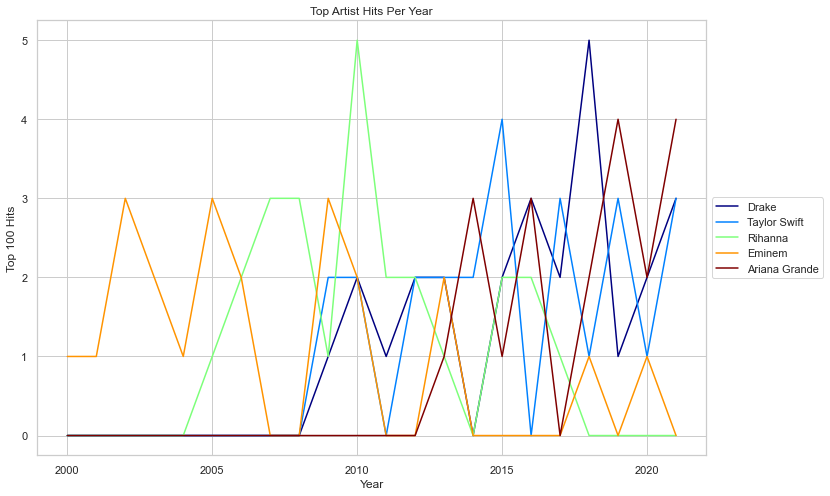

In [71]:
ctab = pd.crosstab([TopSongs['popular_year']], TopSongs['artist_name'])
ctab[top5Artists].plot(kind='line', stacked=False, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Top Artist Hits Per Year")
plt.xlabel('Year');
plt.ylabel('Top 100 Hits');
plt.show()

In [58]:
hits_by_year = TopSongs.groupby(['popular_year','artist_name']).size().reset_index()
#hits_by_year

Artists_Grouped = TopSongs.groupby[['artist_name', 'popular_year']]
Artists_Grouped.head(10)

sns.lineplot(x = "popular_year", y = "Top100",
             hue = "artist_name",
             data = TopSongs)

ctab[genres].plot(kind='line', stacked=False, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [41]:
top_artists = Artists_Grouped[0:9]
top_artists

,Artist,Count
0,Drake,26
1,Taylor Swift,25
2,Rihanna,25
3,Eminem,22
4,Ariana Grande,20
5,Calvin Harris,19
6,P!nk,18
7,Beyoncé,18
8,Britney Spears,16


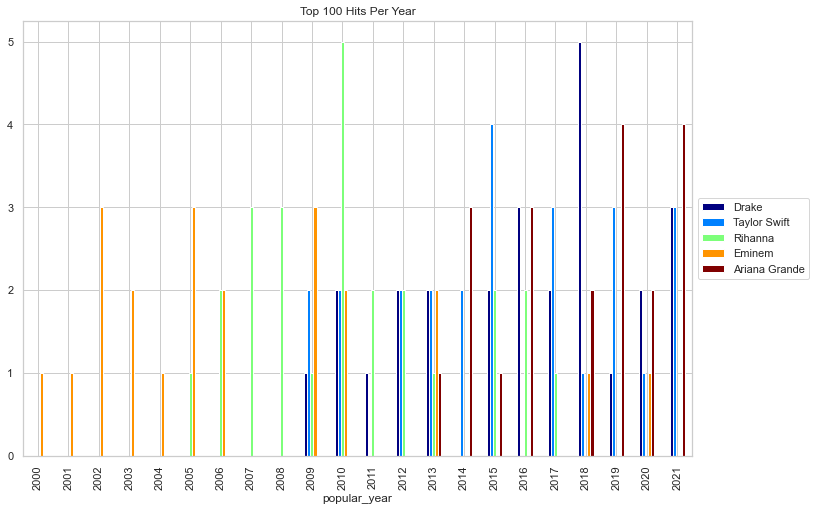

In [72]:
ctab = pd.crosstab([TopSongs['popular_year']], TopSongs['artist_name'])
ctab[top5Artists].plot(kind='bar', stacked=False, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Top 100 Hits Per Year")
plt.show()

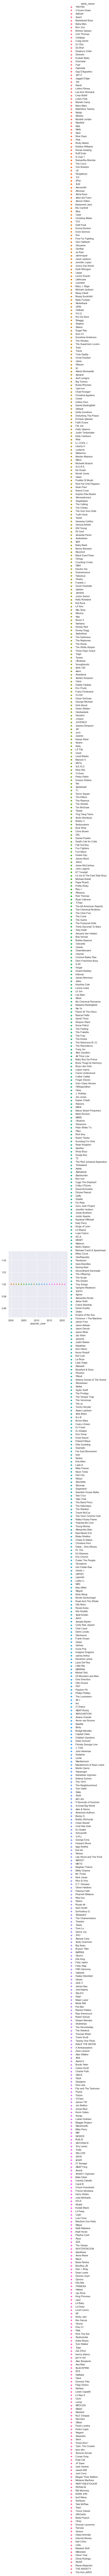

In [20]:
sns.relplot(
    data=hits_by_year, x="popular_year", y=1,
    hue="artist_name", sizes=(10, 100))

#### Let's look at more detail on which artist had the most Top 100 hits - Drake.

In [22]:
DrakeSongs = TopSongs[TopSongs['artist_name'] == "Drake"]
#DrakeSongs = DrakeSongs.groupby('popular_year').count().artist_name.sort_values(ascending=False)
#print(DrakeSongs)
DrakeSongs


,track_id,track_name,track_genre,artist_name,track_popularity,popular_year,Top100,key,acousticness,danceability,...,modality,speechiness,tempo,time_signature,valence,second_artist,artist_country,collaboration,prevTop100,Label
334347,3QLjDkgLh9AOEHlhQtDuhs,Best I Ever Had,hip-hop,Drake,77.0,2009,Y,1.0,0.190000,0.395,...,1.0,0.3750,162.361,4.0,0.5580,NaN,Canada,N,N,Cash Money
413642,4BycRneKmOs6MhYG9THsuX,Find Your Love,hip-hop,Drake,65.0,2010,Y,6.0,0.021100,0.627,...,0.0,0.1700,96.038,4.0,0.7580,NaN,Canada,N,N,Cash Money
418210,6LxSe8YmdPxy095Ux6znaQ,Headlines,hip-hop,Drake,76.0,2011,Y,6.0,0.365000,0.636,...,0.0,0.1060,151.894,4.0,0.4250,NaN,Canada,N,N,Cash Money
418217,4Kz4RdRCceaA9VgTqBhBfa,The Motto,hip-hop,Drake,74.0,2012,Y,1.0,0.000107,0.766,...,1.0,0.3560,201.800,4.0,0.3900,NaN,Canada,N,N,Cash Money
418251,124NFj84ppZ5pAxTuVQYCQ,Take Care,hip-hop,Drake,75.0,2012,Y,0.0,0.026700,0.629,...,0.0,0.2650,121.845,4.0,0.2990,NaN,Canada,N,N,Cash Money
435711,6BdgtqiV3oXNqBikezwdvC,Over,pop,Drake,68.0,2010,Y,7.0,0.010700,0.350,...,1.0,0.2000,99.643,5.0,0.4500,NaN,Canada,N,N,Cash Money
496766,2aSC2xhRxOLiiZZVjhbylH,"Hold On, We're Going Home",hip-hop,Drake,72.0,2013,Y,6.0,0.004210,0.777,...,0.0,0.0946,100.002,4.0,0.2870,NaN,Canada,N,N,Cash Money
496849,5DI9jxTHrEiFAhStG7VA8E,Started From the Bottom,hip-hop,Drake,66.0,2013,Y,8.0,0.031900,0.793,...,1.0,0.1560,86.325,4.0,0.5790,NaN,Canada,N,N,Cash Money
573798,27GmP9AWRs744SzKcpJsTZ,Jumpman,hip-hop,Drake,71.0,2015,Y,1.0,0.055900,0.852,...,1.0,0.1870,142.079,4.0,0.6560,Future,Canada,Y,N,Cash Money
642132,1zi7xx7UVEFkmKfv06H8x0,One Dance,hip-hop,Drake,85.0,2016,Y,1.0,0.007760,0.792,...,1.0,0.0536,103.967,4.0,0.3700,NaN,Canada,N,N,Cash Money


In [23]:
# branko suggestions:
# line chart would be nicer to overlap multiple artists
# choose color pallette that is consistent throughout analysis
# seaborn easier to work with (less code), look nicer

In [24]:
sns.relplot(x="popular_year", y="count",
           data=DrakeSongs, kind="line")

ValueError: Could not interpret value `count` for parameter `y`

In [27]:
sns.catplot(x='popular_year', data=DrakeSongs, kind='line')
plt.show()

ValueError: Plot kind 'line' is not recognized

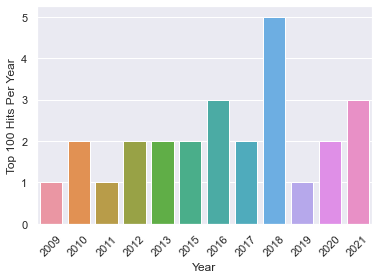

In [28]:
sns.countplot(x='popular_year', data=DrakeSongs)
plt.xticks(rotation=45)
plt.xlabel('Year');
plt.ylabel('Top 100 Hits Per Year');

#### 2018 was an amazing year for Drake!

In [ ]:
#artist_count = TopSongs.groupby('artist_name').count().track_id.sort_values(ascending=False)
#plt.hist(artist_count)

with sns.axes_style('white'):
    g = sns.factorplot("popular_year", data=DrakeSongs, aspect=2,
                       kind="count", color='steelblue')
    g.set_xticklabels(step=5)

#### Let's look at the most popular genres in the Top 100s

In [29]:
Genres_Grouped = TopSongs.groupby('track_genre').count().track_id.sort_values(ascending=False)
Genres_Grouped

track_genre
pop            1057
hip-hop         448
house           144
rock             88
indie            68
alternative      19
dance            19
country          13
r&b               7
Name: track_id, dtype: int64

In [30]:
pop_gen = pd.DataFrame(TopSongs['track_genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'count']
pop_gen.head(10)

,genre,count
0,pop,1057
1,hip-hop,448
2,house,144
3,rock,88
4,indie,68
5,dance,19
6,alternative,19
7,country,13
8,r&b,7


sns.set_theme(style="white")

sns.relplot(x=TopSongs["popular_year"], y=TopSongs["track_genre"], hue="origin", size="weight",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=TopSongs)

''

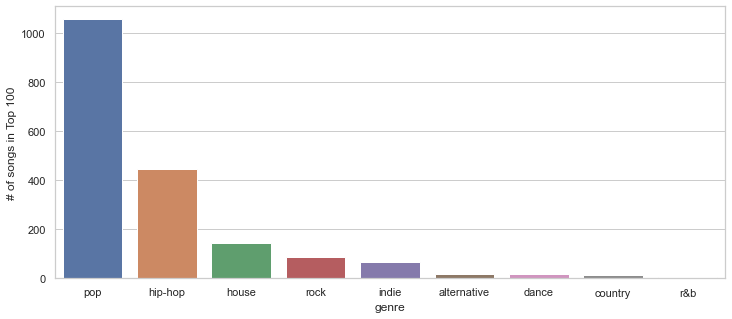

In [31]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
pop_stats = TopSongs.groupby('track_genre').count().track_id.sort_values(ascending=False)

sns.barplot(x=pop_stats.index, y=pop_stats)
plt.xlabel('genre')
plt.ylabel('# of songs in Top 100')
;
# QUESTION: how plot this such that "count" shows up on the y-axis

sns.countplot(x=Genres_Grouped.index, data=Genres_Grouped)
plt.xticks(rotation=90);

In [32]:
TopSongs.head()

,track_id,track_name,track_genre,artist_name,track_popularity,popular_year,Top100,key,acousticness,danceability,...,modality,speechiness,tempo,time_signature,valence,second_artist,artist_country,collaboration,prevTop100,Label
0,3yfqSUWxFvZELEM4PmlwIR,The Real Slim Shady,hip-hop,Eminem,88.0,2000,Y,5.0,0.03020,0.949,...,0.0,0.0572,104.504,4.0,0.760,NaN,United States,N,N,"Aftermath, Interscope, Shady"
12,0I3q5fE6wg7LIfHGngUTnV,Ms. Jackson,hip-hop,Outkast,82.0,2001,Y,4.0,0.14300,0.843,...,0.0,0.2690,94.948,4.0,0.613,NaN,NaN,N,N,NaN
13,3UmaczJpikHgJFyBTAJVoz,Stan,hip-hop,Eminem,85.0,2001,Y,6.0,0.03710,0.780,...,0.0,0.2380,80.063,4.0,0.507,NaN,United States,N,N,"Aftermath, Interscope, Shady"
25,3Gf5nttwcX9aaSQXRWidEZ,Ride Wit Me,hip-hop,Nelly,75.0,2001,Y,7.0,0.06160,0.850,...,1.0,0.0478,101.875,4.0,0.722,NaN,United States,N,N,Universal Motown
44,3wMUvT6eIw2L5cZFG1yH9j,Country Grammar (Hot Shit),hip-hop,Nelly,69.0,2000,Y,2.0,0.00689,0.865,...,1.0,0.1080,162.831,4.0,0.565,NaN,United States,N,N,Universal Motown


#### come back to this one
with sns.axes_style('white'):
    g = sns.factorplot("popular_year", data=TopSongs, aspect=4.0, kind='count',
                       hue='track_genre', order=range(2000, 2021))
    g.set_ylabels('Count')

In [ ]:
#sns.displot(TopSongs, x="popular_year", hue="track_genre");

#### Genres over time

In [ ]:
#sns.displot(TopSongs, x="popular_year", hue="track_genre", multiple="stack", bins=22);

In [ ]:
#gen_df = df.drop('track_genre', axis=1).join(s)

In [ ]:
genres = ['hip-hop', 'house', 'pop', 'r&b', 'rock', 'country', 'dance', 'alternative', 'indie']

In [ ]:
#pop_gen_movies = gen_df[(gen_df['genre'].isin(genres)) & (gen_df['year'] >= 2000) & (gen_df['year'] <= 2017)]
ctab = pd.crosstab([TopSongs['popular_year']], TopSongs['track_genre']).apply(lambda x: x/x.sum(), axis=1)
ctab[genres].plot(kind='bar', stacked=True, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Stacked Bar Chart of Genres in Top 100 per year")
plt.show()

In [ ]:
# branko: line chart could be nice alternative to this
# could make all genres same color, but then highlight one genre with its own color

_Observations on genres over time:_

- Pop and hip-hop have always maintained a sizeable portion of the Top 100
- House music really began to hold a sizable position starting in 2010
- Rock music has faded in recent years

In [ ]:
#TopSongs.popular_year.value_counts()

In [ ]:
TopArtists = pd.DataFrame(TopSongs['artist_name'].value_counts()).reset_index()
TopArtists.columns = ['Artist', 'count']
TopArtists.head(30)
#print(TopArtists)

In [ ]:
TopArtists[TopArtists['count'] == 1].count()

In [ ]:
TopArtists[TopArtists['count'] == 2].count()

In [ ]:
TopSongs.groupby('artist_name').count().track_id.sort_values(ascending=False)

In [ ]:
TopSongs.groupby(['artist_name', 'popular_year']).count().track_id.sort_values(ascending=False)

In [ ]:
TopSongs.groupby(['artist_name', 'popular_year']).count().track_id.sort_values(ascending=False)

In [ ]:
TopLabels = TopSongs.groupby(['Label']).count().track_id.sort_values(ascending=False)
TopLabels

In [ ]:
TopLabels.value_counts()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
pop_stats = TopSongs.groupby('Label').count()['track_id'].sort_values(ascending=False)

sns.barplot(x=pop_stats.index, y=pop_stats)
;
# QUESTION: how plot this such that "count" shows up on the y-axis

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
pop_stats = TopSongs.groupby('Label').count().track_id.sort_values(ascending=False)

sns.barplot(x=pop_stats.index, y=pop_stats)
;
# QUESTION: how plot this such that "count" shows up on the y-axis

In [ ]:
TopLabels.plot()
plt.xticks(rotation=30)
plt.show()

In [ ]:
TopLabels.info()

In [ ]:
TopSongs.groupby(['artist_country']).count().track_id.sort_values(ascending=False)

In [ ]:
TopSongs[TopSongs['artist_country']=='Colombia']

In [ ]:
df.corr()

### Observations on correlation matrix: 
there does not appear to be much correlation between the availble variables.  The only variables with a coefficient higher than +_0.5 are:
 - Energy/Acousticness
 - Danceability/Valence
 - Loudness/Accousticness
 - Energy/Loudness
 - Acousticness/Loudness
 - Loudness/Instrumentalness
 
 It's worth noting that Loudness is included in four of these pairs (could be a candidate for removal)

In [ ]:
df.describe()

In [ ]:
#sns.pairplot(df4)

In [ ]:
#seaborn.histplot(data, x, y, hue, stat, bins, binwidth, discrete, kde, log_scale)

sns.histplot(df4.key)


sns.histplot(data=df4.key, x="sepal_length")
plt.show()

In [ ]:
# look at atrributes over time
# are these attributes different by country
# only include song attributes here, exclude categorical

### Let's look at the numerical variables

In [ ]:
df.key.value_counts()

In [ ]:
df_numerical = df[['track_popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]
#df_numerical = df.loc[df[:, 'track_popularity', 'key']]

In [ ]:
df_numerical.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

In [ ]:
#boxplot_data = pd.DataFrame(df4.drop(columns='duration_ms',inplace=True))
#df4.liveness.boxplot(figsize=(15,8))
#plt.show()
#boxplot_data.head()

def
for column in df4:
    quality_normal = 

column_list = list(df4.columns)

[stats.normaltest(df4[(column)]) for column in column_list]

plt.hist(df4.key)
plt.xlabel('key')
plt.ylabel('count');

quality_normal = stats.normaltest(df4.key)
print(quality_normal)

In [ ]:
stats.normaltest(df['acousticness'])

In [ ]:
stats.normaltest(df.danceability)

In [ ]:
plt.hist(df.acousticness)
plt.xlabel('acousticness')
plt.ylabel('count');

quality_normal = stats.normaltest(df5.acousticness)
print(quality_normal)

For feature engineering, can derive:
- artist age from kaggle file that I found
- collaboration (based on second artist, or based on "featuring")
- if they previously appeared on a top 100 list
- look at major record labels and independents

#### write to CSV
from pathlib import Path  
filepath = Path('/Users/gregwelliver/Desktop/springboard_files/Capstone Two - Music/Data/Merged_Data.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df3.to_csv(filepath)

df4 = df4.rename(columns = {'mode':'modality'})

In [ ]:
# y-axis in bold
rc('font', weight='bold')
 
# Values of each group
bars1 = df2.query("Artist == 'Drake'")
bars2 = df2.query("Artist == 'Taylor Swift'")
bars3 = df2.query("Artist == 'Rihanna'")
bars4 = df2.query("Artist == 'Eminem'")
bars5 = df2.query("Artist == 'Ariana Grande'")


# Heights of bars1 + bars2
bars = np.add(bars1, bars2, bars3).tolist()
 
# The position of the bars on the x-axis
r = [0,1,2,3,4]
 
# Names of group and bar width
names = ['A','B','C','D','E']
barWidth = 1
 
# Create brown bars
plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth)
# Create green bars (middle), on top of the first ones
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=barWidth)
# Create green bars (top)
plt.bar(r, bars3, bottom=bars, color='#2d7f5e', edgecolor='white', width=barWidth)
# Create TBD bars (top)
plt.bar(r, bars4, bottom=bars, color='#2d7f5e', edgecolor='white', width=barWidth)
# Create TBD bars (top)
plt.bar(r, bars5, bottom=bars, color='#2d7f5e', edgecolor='white', width=barWidth)


# Custom X axis
plt.xticks(r, names, fontweight='bold')
plt.xlabel("group")
 
# Show graphic
plt.show()

In [ ]:
bar chart time series:
genres = ['hip-hop', 'house', 'pop', 'r&b', 'rock', 'country', 'dance', 'alternative', 'indie']
ctab = pd.crosstab([TopSongs['popular_year']], TopSongs['track_genre'])
ctab[genres].plot(kind='bar', stacked=True, colormap='Accent', figsize=(14,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Stacked Bar Chart of Genres in Top 100 per year")
plt.show()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
pop_stats = TopSongs.groupby('Label').count()['track_id'].sort_values(ascending=False)

sns.barplot(x=pop_stats.index, y=pop_stats)
;
# QUESTION: how plot this such that "count" shows up on the y-axis

In [ ]:
# line chart
ctab = pd.crosstab([TopSongs['popular_year']], TopSongs['artist_name'])
ctab[top5Artists].plot(kind='line', stacked=False, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Top Artist Hits Per Year")
plt.xlabel('Year');
plt.ylabel('Top 100 Hits');
plt.show()

In [ ]:
# Make a data frame
#df = Artists_Grouped.query("Artist == Ed Sheeran")
 
# Change the style of plot
plt.style.use('seaborn-darkgrid')
 
# Create a color palette
palette = plt.get_cmap('Set1')
 
# Plot multiple lines
num=0
for column in df2.drop('Year', axis=1):
    num+=1
    plt.plot(df2['Year'], df2[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)

# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("A (bad) Spaghetti plot", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time")
plt.ylabel("Score")

# Show the graph
plt.show()

#### extra genre plots:

In [1]:
pop_gen = pd.DataFrame(TopSongs['track_genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'count']
pop_gen.head(10)

NameError: name 'pd' is not defined

In [ ]:
sns.set_theme(style="white")

sns.relplot(x=TopSongs["popular_year"], y=TopSongs["track_genre"], hue="origin", size="weight",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=TopSongs)

In [ ]:
sns.countplot(x=Genres_Grouped.index, data=Genres_Grouped)
plt.xticks(rotation=90);

In [ ]:
#### come back to this one
with sns.axes_style('white'):
    g = sns.factorplot("popular_year", data=TopSongs, aspect=4.0, kind='count',
                       hue='track_genre', order=range(2000, 2021))
    g.set_ylabels('Count')

In [ ]:
#sns.displot(TopSongs, x="popular_year", hue="track_genre");

### collaboration extras

In [ ]:
TopCollabs2 = TopSongs.groupby(['popular_year']).collaboration.value_counts()
TopCollabs2

In [2]:
TopCollabs = TopSongs[['popular_year', 'collaboration']].value_counts().reset_index()
#TopCollabs.index = TopCollabs.index + 1
TopCollabs.columns = ['Year', 'Collaboration?', 'Count']
TopCollabs.sort_values('Year').reset_index(drop=True)
#TopCollabs.head(30)

NameError: name 'TopSongs' is not defined

https://www.python-graph-gallery.com/242-area-chart-and-faceting

In [ ]:
### QUESTION: when we have a categorical independent variable, is there much EDA that we can do with it?
### QUESTION: what do with variables we know are categorical, but python is reading as continuous (e.g. key, modality)
#QUESTION: how quickly modify colors? seems there are different ways of doing this. sometimes create an array of colors to pass in, other times can select a colormap
# is it different per chart type? what's the simplest way to manage this?
# QUESTION: quick way to spin up cumulative charts with time as one axis?
# QUESTION: how do it with time zero for each artist being when their first hit occurred, and then each additional year being another year out on the axis?

In [2]:
# branko suggestions:
# line chart would be nicer to overlap multiple artists
# choose color pallette that is consistent throughout analysis
# seaborn easier to work with (less code), look nicer
#branko convo: think about the insight you are trying to convey.  if it requires each artist have its own chart, then do it that way
# showing the cumulative number of hits over years may be a good thing to show
# branko: line chart could be nice alternative to this
# could make all genres same color, but then highlight one genre with its own color

Branko January 11:
- nicely structured, cleaned up visualizations
- overall narrative - sending article. exploratory versus explanatory. further explanatory could also come at the end, final presentation
- opportunity to extend further; can dive deeper?
- example: how do song attributes change over time? what are song attributes within genres?
- can come back to go deeper on this at a later date


SyntaxError: invalid syntax (2126146047.py, line 10)

In [1]:
# concatenate with list comprehension:
#df_af_list = list(df_af.columns)
#df_af_list = ['_'.join(['df_af.', x]) for x in df_af_list]
#df_af_list

### list comprehehension where pass in the data columns for normaltest:
normaltest_output = [stats.normaltest(df_af[col]) for col in df_af.columns]
normaltest_output